### Случайный лес и bias-variance tradeoff

### План семинара:

1. [Случайный лес](#randomforest)
2. [Bias-variance decomposition](#decompose)


In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from mlxtend.data import iris_data
from mlxtend.evaluate import bias_variance_decomp
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm

plt.rcParams["figure.figsize"] = (10, 8)

## Случайный лес <a name="randomforest"></a>

Вспомним, из каких шагов складывается обучение случайного леса. Алгоритм из $ N$ деревьев, выглядит следующим образом:


Для каждого $n = 1, \dots, N$: <br>
1. Сгенерировать выборку $ X_n$ с помощью бутстрапа; <br>
2. Построить решающее дерево $ b_n$ по выборке $ X_n$: <br>
— по заданному критерию выбираем лучший признак, делаем разбиение в дереве по нему и так до исчерпания выборки <br>
— дерево строится, пока в каждом листе не более $ n_\text{min}$ объектов или другому критерию останова <br>
— при каждом разбиении сначала выбирается $ m$ случайных признаков из $ n$ исходных, 
и оптимальное разделение выборки ищется только среди них.

Так, при построении каждого дерева при созданию нового узла случайным образом выбираем набор признаков для разбиения. Таким образом, мы снизим дисперсию итоговой модели, поскольку уменьшаем скоррелированность деревьев. 

Итоговый классификатор имеет вид $ a(x) = \frac{1}{N}\sum_{i = 1}^N b_i(x)$, где $b_i$ - одно из деревьев (базовый алгоритм). Для задачи кассификации мы выбираем класс через правило голосования большинства, а в задаче регрессии — берем средний прогноз.


Возьмем датасет для задачи многоклассовой классификации и обучим для ее решения случайный лес:

In [5]:
X, y = iris_data()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=y)


rfc = RandomForestClassifier(random_state=42)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        rfc, X_train, y_train, X_test, y_test, 
        loss='0-1_loss',
        random_seed=42)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.084
Average bias: 0.111
Average variance: 0.031


Для сравнения, посчитаем усредненные смещение и дисперсию для более простого алгоритма (решающего дерева):

In [6]:
tree = DecisionTreeClassifier(random_state=42)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        tree, X_train, y_train, X_test, y_test, 
        loss='0-1_loss',
        random_seed=42)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.079
Average bias: 0.111
Average variance: 0.047


Сравните ошибку, смещение и дисперсию двух данных алгоритмов.

**Вопросы на обсуждение**:
1. Что такое out-of-bag ошибка?
2. Может ли случайный лес переобучиться?

1. **Out-of-bag-ошибка** - это усредненная ошибка на непопавших в выборку объектах по всему итоговому алгоритму.  

Вспомним, что при обучении случайного леса каждое дерево строится на подвыборке, бустрапированной из исходной обучающей выборки. Соответственно, будут такие наблюдения, которые ни разу не попадут ни в одну из подвыборок. Данные объекты можно использовать для валидации при оценке качества алгоритма. Для этого, воспользуемся при инициализации модели параметром `oob_score`. 

In [7]:
data = load_diabetes()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

model = RandomForestRegressor(n_estimators=50, oob_score=True, random_state=42)
model.fit(X_train, y_train)
model.oob_score_

0.4113436302180531

2. Попробуем ответить на вопрос, изспользуя датасет по предсказанию степени диабета (в диапазоне вещественных чисел 25 - 346) для задачи регрессии, построив случайный лес для разного количества деревьев.

100%|██████████| 49/49 [00:02<00:00, 18.22it/s]


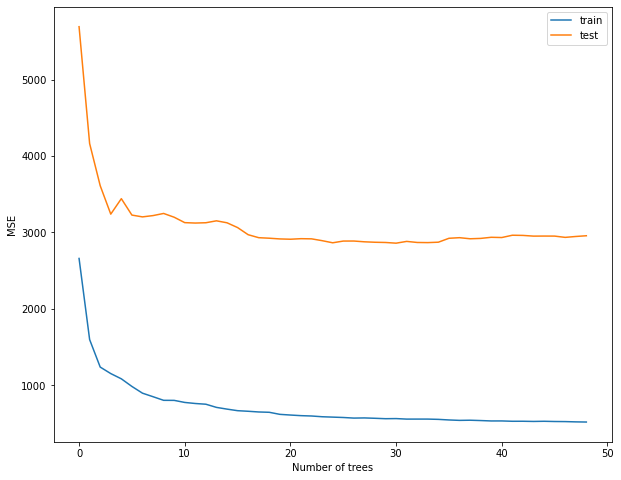

In [8]:
train_mse, test_mse = [], []
n_trees = 50

for i in tqdm(range(1, n_trees)):
    model = RandomForestRegressor(n_estimators=i, random_state=42)
    model.fit(X_train, y_train)
    train_mse.append(mean_squared_error(y_train, model.predict(X_train)))
    test_mse.append(mean_squared_error(y_test, model.predict(X_test)))
    
plt.plot(train_mse, label='train')
plt.plot(test_mse, label='test')
plt.xlabel('number of trees')
plt.ylabel('MSE')
plt.xlabel('Number of trees')
plt.legend();

Видно, что графики напоминают геометрическое распределение, и что при определенном значении количества деревьев ошибка начинает убывать уже слабее. Какой вывод можно сделать с точки зрения переобучения при увеличении числа деревьев? 

Попробуйте провести эксперименты относительно переобучения случайного леса, поменяв другие параметры, например, `max_depth`. 

### Калибровка вероятностей

Некоторые алгоритмы в качестве прогнозов выдают предсказанные вероятности, например, как мы это видели в логистической регрессии. 
Другие алгоритмы, такие как деревья решений и случайный лес, напрямую не производят предсказания вероятностей, и вместо этого предсказание вероятностей должно быть аппроксимировано.

Это можно сделать с помощью калибровки - операции масштабирования, которая применяется после того, как предсказания были сделаны предсказательной моделью. Например, с помощью калибровки Платта, рассмотренной на лекции и хорошо работающее при искажении в предсказанных вероятностях в виде сигмовидной формы,  или изонотонической регрессии, которая может исправить любое монотонное искажение.

Вы можете диагностировать калибровку классификатора, создав диаграмму достоверности фактических вероятностей в зависимости от прогнозируемых вероятностей в тестовом наборе - построить калибровочную кривую ```calib_curve()```

Функция ```calib_curve()``` принимает истинные значения класса для набора данных и прогнозируемые вероятности для основного класса (класс = 1). Она возвращает истинные вероятности и предсказанные вероятности для каждого бина. Количество бинов можно указать через `n_bins` аргумент, по умолчанию их 5.

In [9]:
from sklearn.datasets import load_breast_cancer
from sklearn.calibration import calibration_curve

data = load_breast_cancer()
X, y = data.data, data.target

model = RandomForestClassifier()
model.fit(X, y)

RandomForestClassifier()

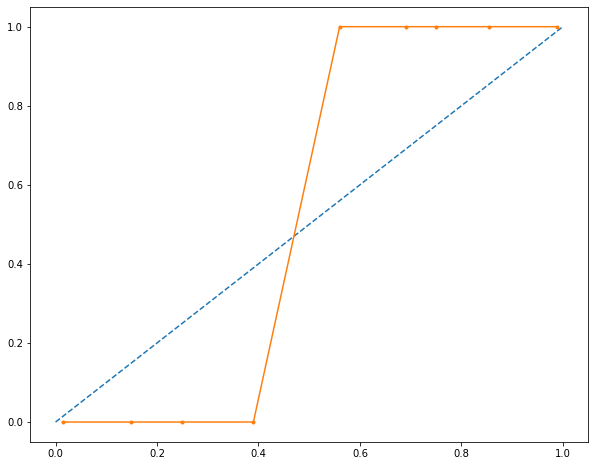

In [10]:
probs = model.predict_proba(X)[:,1]

# калибровочная кривая
fop, mpv = calibration_curve(y, probs, n_bins=10)

# идеальная калибровка
plt.plot([0, 1], [0, 1], linestyle='--')
# надежность модели
plt.plot(mpv, fop, marker='.')
plt.show()

Так же, в sklearn есть класс [`CalibratedClassifierCV`](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html), который сделает кросс-валидацию, используя для калибровку логистическую или изотоническую регрессию.

In [11]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

X, y = make_classification(n_samples=100, 
                           n_features=2,
                           n_redundant=0, 
                           random_state=42)

clf = RandomForestClassifier()
clf.fit(X, y)
clf.predict_proba(X)[:5, :]

array([[0.69, 0.31],
       [0.  , 1.  ],
       [0.97, 0.03],
       [0.98, 0.02],
       [0.  , 1.  ]])

In [12]:
calibrated_clf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(), cv=3, method='isotonic')
calibrated_clf.fit(X, y)
calibrated_clf.predict_proba(X)[:5, :]

array([[0.74203789, 0.25796211],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ]])

## Bias - variance decomposition <a name="decompose"></a>

Ошибка любой модели складывается из 3 факторов: сложности выборки, схожести обученной модели с истинной зависимостью с ответами в выборке и свойств семейства, к которому относится выбранная модель. Между этими факторами существует баланс, при котором увеличение одной составляющей приводит к уменьшению другой. 

Любую функцию ошибки можно разложить на три компоненты, описывающие сложность и качество построенного алгоритма: **смещение** (bias), **дисперсию** (variance) и **шум** (noise). 

Рассмотрим разложение на смещение и дисперсию на примере задачи регрессии. 

Пусть задана некоторая выборка $(x_i, y_i)$, при $i = 1, ..., N$, прогнозы для каждого i-го объекта обозначим как $\hat y_i$. Рассмотрим уже известную нам квадратичную функцию потерь: $Q(a, y) = (y - \hat y)^2$. Математическое ожидание среднеквадратичной ошибки можно представить как:

$$\mathbb{E}[y - \hat{y}]^2 = bias^2 + variance + noise,$$

где

|||||
|---|---|:---:|---|
|смещение|$\mathrm{bias}$|$\mathbb{E}(\hat{y}) - y$|ошибка из-за простоты модели (отклонение среднего прогноза модели от истинных ответов)|
|дисперсия|$\mathrm{variance}$|$\mathbb{E}[\mathbb{E}(\hat{y}) - \hat{y}]^2$| ошибка из-за сложности модели (разброс прогнозов модели относительно ее среднего прогноза|
|шум|$\mathrm{noise}$|$\mathbb{E}[y - \mathbb{E}(y)]^2$|ошибка идеальной модели (из-за наличия шума в данных)|


Разбор разложения MSE на смещение и дисперсию в общем виде можно посмотреть в лекции или [тут](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture08-ensembles.pdf) в общем виде. 

**Задача**. Истинная зависимость имеет вид $y_i = x^2_i +u_i$, где $y_i$ — прогнозируемая переменная, $x_i$ — предиктор и $u_i$ — ненаблюдаемая случайная составляющая. Величины $x_i$ независимы и равновероятно принимают значения 1 и 2. Величины $u_i$ независимы и равновероятно принимают значения −1 и 1. Начинающий машин-лёрнер Василий может позволить себе обучающую выборку только из двух наблюдений.

Разложите ожидание квадрата ошибки прогноза на шум, смещение и разброс, если: <br>
1) вне зависимости от обучающей выборки из-за ошибки в коде в качестве прогноза всегда выдаётся 0. <br>
2) вне зависимости от обучающей выборки из-за ошибки в коде в качестве прогноза равновероятно выдаётся -1 или 1. <br>
3) в качестве прогноза разработанный Василием новейший алгоритм всегда выдаёт последний y из обучающей выборки. <br>

Давайте рассмотрим пример решения задачи регресси на данных с наличием нелинейных связей - например, через сигмоиду, как предложено [здесь](https://dyakonov.org/2018/04/25/%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D0%B5-bias-%D0%B8-%D1%80%D0%B0%D0%B7%D0%B1%D1%80%D0%BE%D1%81-variance-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82/comment-page-1/). 

Сгенерируем случайную выборку:

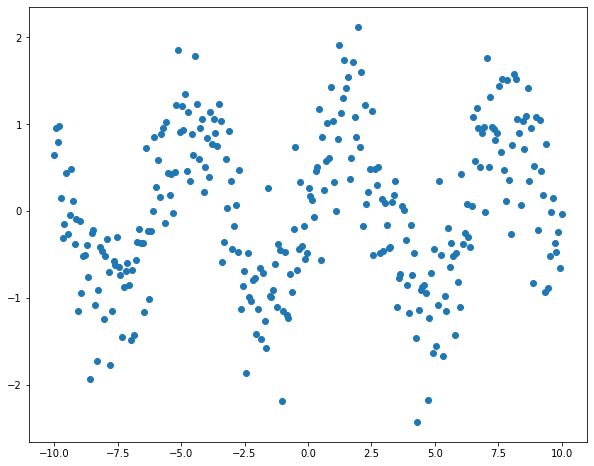

In [13]:
N = 300
X = np.linspace(-10, 10, N).reshape(-1, 1)
y = np.sin(X) + np.random.normal(0, 0.5, N).reshape(-1, 1)
plt.scatter(X, y);

Давайте посмотрим на модели с разной сложностью и проанализируем их с точки зрения смещения и дисперсии. Построим модель линейной регрессии на признаке X, а потом попробуем усложнять эту модель через добавление новых полиноминальных признаков с разной степенью.

In [14]:
def train_polinomial_reg(degree=1):
    polynomial = PolynomialFeatures(degree)
    new_features = polynomial.fit_transform(X)
    polreg = LinearRegression()
    polreg.fit(new_features, y)
    preds = polreg.predict(new_features)
    return preds

# Линейная регрессия
linreg = train_polinomial_reg(1)

# Регрессия на полиноминальных признаках со степень 5
polinoms_5 = train_polinomial_reg(5)

# Регрессия на полиноминальных признаках со степень 15
polinoms_15 = train_polinomial_reg(15)

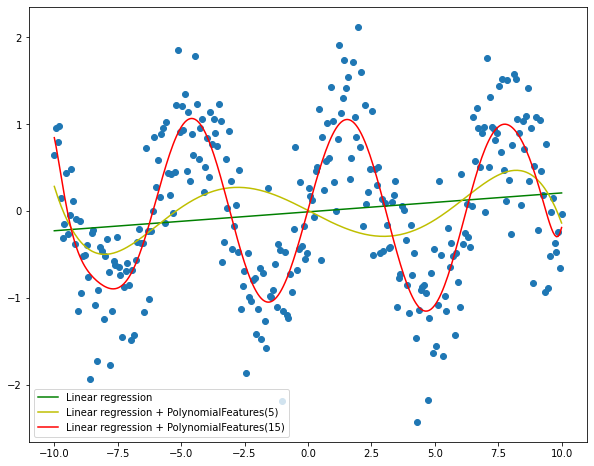

In [15]:
plt.scatter(X, y)
plt.plot(X, linreg, label='Linear regression', c='g')
plt.plot(X, polinoms_5, label='Linear regression + PolynomialFeatures(5)', c='y')
plt.plot(X, polinoms_15, label='Linear regression + PolynomialFeatures(15)', c='r')
plt.legend();

Как можно увидеть на графиках, простые модели недообучаются, сложные модели - переобучаются. Простая модель имеет высокую дисперсию и малое смещение, и в данном случая простая линейная регрессия (с полиномом первой степени) плохо подходит для описания целевой переменной. В то же время, более сложные модели по мере увеличения степени полинома имеет меньшую дисперсию, но большее смещение. 

|||||
|---|---|:---:|---|
|**model's complexity**|**bias**|**variance**
|simple|high|low
|complex|low| high


При этом, на обучающей выборке ошибка MSE будет, действительно, убывать по мере увеличения степени полинома:

In [17]:
[mean_squared_error(x, y) for x in [linreg, polinoms_5, polinoms_15]]

[0.768270385986397, 0.7115437401820734, 0.258606347157613]

Но если мы поделим выборку на train и test, и будем оценивать ошибку на тесте, то увидим переобучение при возрастающей сложности алгоритма:

In [18]:
train_size = 200 

def get_preds_on_test(degree=1, train_size=200):
    polynomial = PolynomialFeatures(degree)
    new_features = polynomial.fit_transform(X)
    polreg = LinearRegression()
    X_train, y_train = new_features[:train_size], y[:train_size]
    X_test, y_test = new_features[train_size:], y[train_size:]
    polreg.fit(X_train, y_train)
    preds = polreg.predict(X_test)
    return preds

linreg = get_preds_on_test(1, 200)
polinoms_5 = get_preds_on_test(5, 200)
polinoms_15 = get_preds_on_test(15, 200)
y_test = y[train_size:]


[mean_squared_error(x, y_test) for x in [linreg, polinoms_5, polinoms_15]]

[1.0933774760621082, 19102.4759198038, 2389514688942.811]

<img src='http://neerc.ifmo.ru/wiki/images/1/18/Bias-Variance-Tradeoff.png'>

Подводя небольшой итог - нам приходится искать компромисс между между простотой и сложностью модели, между недообучением и переобучением. С точки зрения смещения и дисперсии, обычно наилучшее качество достигается при средних значениях обоих.

Дополнительные материалы:

1) [Блог Александра Дьяконова. Анализ малых данных. Смещение (bias) и разброс (variance)](https://dyakonov.org/2018/04/25/%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D0%B5-bias-%D0%B8-%D1%80%D0%B0%D0%B7%D0%B1%D1%80%D0%BE%D1%81-variance-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82/comment-page-1/)